This code is for M_SD_50 (Matrix seed dispersal 30x20)

In [1]:
#Libraries needed
import igraph as ig
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import statistics
import networkx as nx
import scipy

In [2]:
########## Program #########
dir = os.getcwd()  # Folder where the program is
Experiment = 'M_SD_50' #Name of the experiment
beta = 0.002 # Values of beta, in this case 0.002 as this value as forced
Normalized = 0.75 #Value to normalize the matrix

In [3]:
MGL = [] #Matrix from the databases, narmalized
MCL = [] # Matrix from the databases, normalized and put in the form of (6) matrix from the paper 
VL = [] # Vector with the number of vertex of each web
D1 = [] # Vector with the dimension 1 of each web
D2 = [] # Equal to D1 but with dimension 2
databases = [] # Vector with the name of the databases to be used
MatrixGraphs = [] # Vector with graph matrix 
D1 = [] # Vector with dimension 1
D2 =[] # Vector with dimension 2
VL= [] # Vector with number of vertex

In [4]:
databases_dir = '/databases/M_SD_W'  # Directory of the databases

In [5]:
files = os.listdir(dir + databases_dir)

In [6]:
#First way, it writes as ['item',..]
f = open('filedata.txt', 'w') # .txt where put the list with the names of the databases
f.write(str(files)) # Write the list
f.close() # Close the file

In [7]:
#Second way, it writes as a list (as in original program)
with open ('filedata.txt', 'w') as f:
    for item in files:
        f.write("%s\n" % item)
    f.close()

In [8]:
# This rutine allows to read the csv and put into a matrix using pandas
files_db = []
for db in files: 
    data = pd.read_csv(dir + databases_dir + '/' + db, header = None) # Row data
    rows = data.shape[0] # Size of the first set of species
    cols = data.shape[1] # Size of the second set of species
    dim1 = rows
    dim2 = cols
    if (dim1>19 and dim2>29) or (dim1>29 and dim2>19):
        if (dim1<=dim2):
            dim1 = 20
            filas = 20
            dim2 = 30
            cols = 30
        else:
            dim1 = 30
            filas = 30
            dim2 = 20
            cols = 20
        files_db.append(db)
        vertexs = dim1 + dim2
        databases.append(db) #Inclusion of the databases in a list to know which databases are being used
        # Normalizing and creation of the graph matrix
        #zero_data = np.zeros(shape=(len(data),len(data)))
        zero_data = np.ones(shape=(vertexs,vertexs))
        MatrixGraphP = pd.DataFrame(zero_data)
        #Create the matrix
        # Part of the cooperation
        for i in range(dim1):
            for j in range(dim1, vertexs):
                MatrixGraphP.loc[i,j] = data.loc[i,j-dim1] #This part is what is in the database 
                MatrixGraphP.loc[j,i] = data.loc[i,j-dim1] #This part is what is in the database
        
        sumatory = [] #To calulte the sum of the rows
        for index, row in MatrixGraphP.iterrows():
            sumatory.append(row.sum())
        Maxi = max(sumatory)
        MatrixGraphP = Normalized*MatrixGraphP/Maxi
        # Part of the competition
        for i in range(dim1):
            for j in range(dim1):
                MatrixGraphP.loc[i,j] = beta
        
        for i in range(vertexs-dim2, vertexs):
            for j in range(vertexs-dim2, vertexs):
                MatrixGraphP.loc[i,j] = beta
                
                #Diagonal
        for i in range(vertexs):
                MatrixGraphP.loc[i,i] = 0
    
        #Gathering all the data
        MatrixGraphs.append(MatrixGraphP)
        D1.append(dim1)
        D2.append(dim2)
        VL.append(vertexs)
    
        
    MatrixGraphP.to_csv(dir + '/proof.csv', sep = ";")
    
        

In [9]:
#MatrixGraphP

In [10]:
for matrix in MatrixGraphs:
    MGL.append(matrix.copy())


In [11]:
# Network matrix
for matrix in MGL:
    MCL.append(matrix.copy())

for matrix in range(len(MCL)):
    # Gamma value are negatives
    for i in range(D1[matrix], VL[matrix]):
        for j in range(D1[matrix]):
            MCL[matrix].loc[i,j] = - MCL[matrix].loc[i,j]
            MCL[matrix].loc[j,i] = - MCL[matrix].loc[j,i]
    #Diagonal equal to 1
    for i in range( VL[matrix]):
        MCL[matrix].loc[i,i] = 1
        
    

In [12]:
#MGL[0]

In [13]:
# Calculating mean and standard deviation
Mean = []
Std = []
for Matrix in MCL:
    Mean.append(-Matrix[Matrix <=0].mean().mean()*2)
    Std.append(Matrix[Matrix <=0].std().std()*2)
    

In [14]:
Mean_Total = statistics.mean(Mean)
Std_Total = statistics.mean(Std)

In [15]:
#Mean, Std, 
Mean_Total, Std_Total

(0.007941294624366883, 0.02153849228588957)

In [16]:
Elements = []
for Matrix in MCL:
    Elements.append(Matrix[(Matrix>0.0001) | (Matrix<-0.0001)].count().sum()/2-(50+30*20))
Elements_mean=statistics.mean(Elements)
Elements_Std=statistics.stdev(Elements)
#Elements, 
Elements_mean, Elements_Std

(157.25, 76.80006510413907)

In [17]:
# Generating the matrix to use in CgrilliJR
for i in range(0,len(MCL)): 
    textfile = open("databases_"+Experiment+"_flat/"+databases[i]+"_In.lst", "w")
    Matrix = MCL[i].values.flatten()
    for element in Matrix:
        textfile.write(str(element) + "\n")
    textfile.close()

In [18]:
# Calling the program to calculate the structural stability
os.remove("Out_"+Experiment+".txt") if os.path.exists("Out_"+Experiment+".txt") else False
for i in range(0,len(databases)):
    matrix = open("databases_"+Experiment+"_flat/"+databases[i]+"_In.lst", "r")
    # subprocess.run(["./StructuralStab", str(VL[i]), "databases_flat/"+databases[i]+"_In.lst", databases[i]+"_Out.txt", "-1"], capture_output=False)
    subprocess.run(["./StructuralStab", str(VL[i]), "databases_"+Experiment+"_flat/"+databases[i]+"_In.lst", "Out_"+Experiment+".txt", "-1"], capture_output=False)

In [19]:
# Reading the result
result = pd.read_csv("Out_"+Experiment+".txt",sep = " ", header = None)

In [20]:
List_Stab = result.to_numpy().transpose().tolist()

In [21]:
#List_Stab[2]

In [22]:
# Calculate mean grade and gamma minus beta
##Mean Grade
meangrade = []
for matrix in MGL:
    matrix_abs = matrix.copy()
    matrix_abs = matrix_abs.abs()
    meangrade_matrix = matrix_abs.sum().sum()/(2*matrix.shape[0])
    meangrade.append(meangrade_matrix)
    
## Gamma minus Beta
gammaminusbeta = []
for matrix in MCL:
    gammaminusbeta_matrix = (-matrix.sum().sum() + matrix.shape[0])/(2*matrix.shape[0])
    gammaminusbeta.append(gammaminusbeta_matrix)
    

In [23]:
#meangrade

In [24]:
#gammaminusbeta

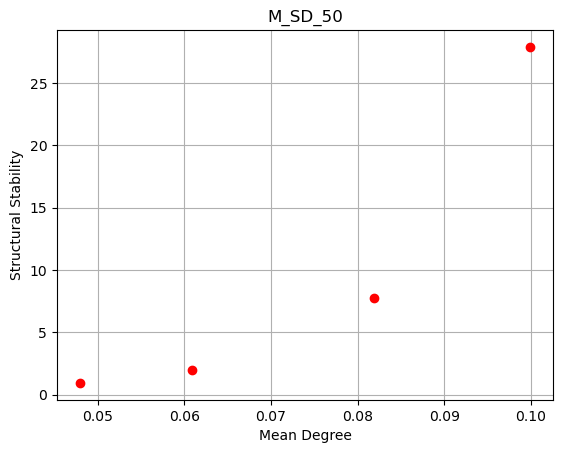

In [25]:
# Generating Plots of meangrade
plt.plot(meangrade, List_Stab[2], "ro")
plt.xlabel('Mean Degree')
plt.ylabel('Structural Stability')
plt.title(Experiment)
plt.grid(True)
plt.show()

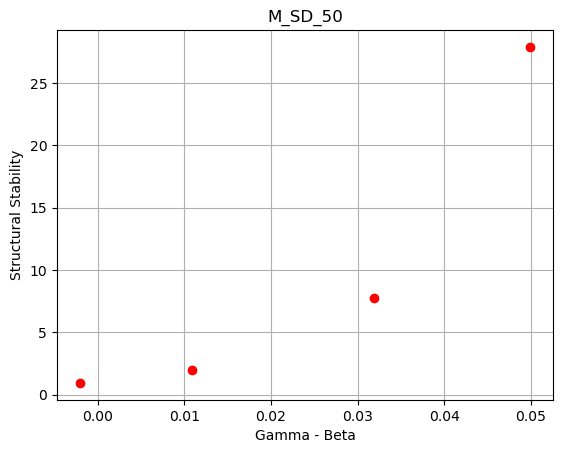

In [26]:
# Generating Plots of gammaminusbeta
plt.plot(gammaminusbeta, List_Stab[2], "ro")
plt.xlabel('Gamma - Beta')
plt.ylabel('Structural Stability')
plt.title(Experiment)
plt.grid(True)
plt.show()

In [27]:
# Calculate sum of cooperation and competition
sum_coop = [] # Sum of cooperation
sum_comp = [] # Sum of competition
for matrix in MCL:
    suma = (matrix.values).tolist()
    sum_comp_rel = []
    sum_coop_rel = []
    for vector in suma:
        sum_comp_rel.append(sum([comp for comp in vector if (comp >0 and comp != 1.0)]))
        sum_coop_rel.append(sum([coop for coop in vector if coop <=0]))
    sum_comp.append(sum(sum_comp_rel)/(2*matrix.shape[0]))
    sum_coop.append(-sum(sum_coop_rel)/(2*matrix.shape[0]))

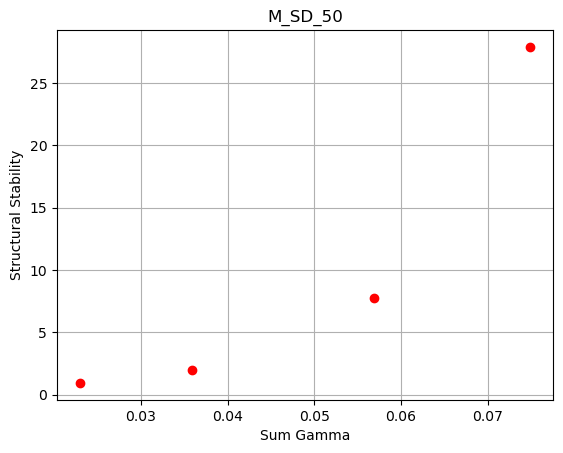

In [28]:
# Generating Plots of sum of gamma
plt.plot(sum_coop, List_Stab[2], "ro")
plt.xlabel('Sum Gamma')
plt.ylabel('Structural Stability')
plt.title(Experiment)
plt.grid(True)
plt.show()

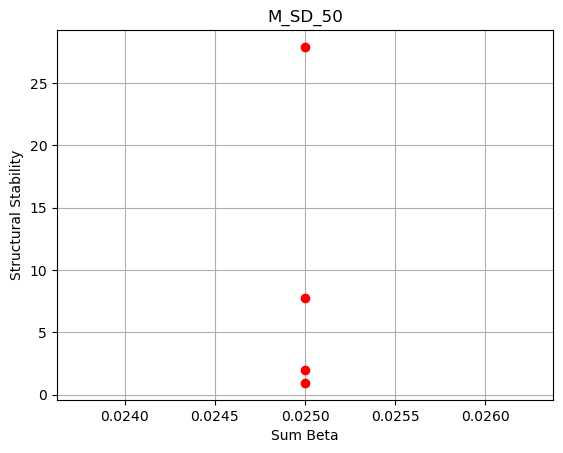

In [29]:
# Generating Plots of sum of gamma
plt.plot(sum_comp, List_Stab[2], "ro")
plt.xlabel('Sum Beta')
plt.ylabel('Structural Stability')
plt.title(Experiment)
plt.grid(True)
plt.show()

In [30]:
# Modularity review
Modul_eig = []
Modul_opt = []
Modul_greedy = []
for i in range(0,len(MGL)):
    print(i)
    Graph = MGL[i].values
    g = ig.Graph.Weighted_Adjacency((Graph).tolist(), mode = 'undirected')
    communities_eig = g.community_leading_eigenvector(weights = g.es['weight'])
    communities_opt = g.community_optimal_modularity(weights = g.es['weight'])
    communities_greedy = g.community_fastgreedy(weights = g.es['weight']).as_clustering()
    modula_eig = g.modularity(communities_eig)
    modula_opt = g.modularity(communities_opt)
    modula_greedy = g.modularity(communities_greedy)
    Modul_eig.append(modula_eig)
    Modul_opt.append(modula_opt)
    Modul_greedy.append(modula_greedy)

0
1
2
3


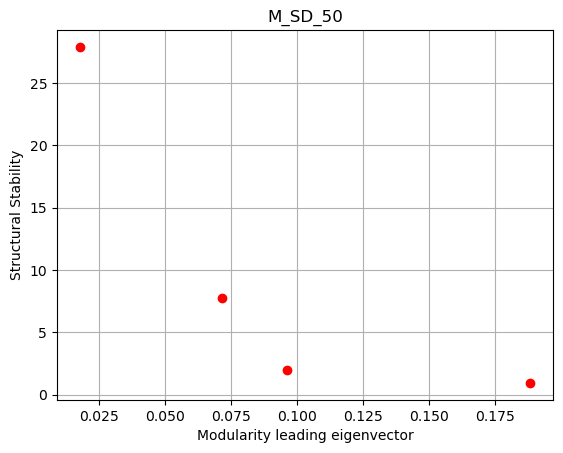

In [31]:
# Generating plots modularity
plt.plot(Modul_eig, List_Stab[2], "ro")
plt.xlabel('Modularity leading eigenvector')
plt.ylabel('Structural Stability')
plt.title(Experiment)
plt.grid(True)
plt.show()

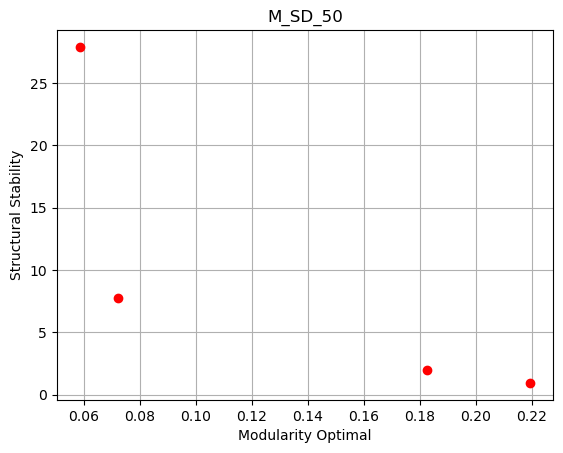

In [32]:
# Generating plots modularity
plt.plot(Modul_opt, List_Stab[2], "ro")
plt.xlabel('Modularity Optimal')
plt.ylabel('Structural Stability')
plt.title(Experiment)
plt.grid(True)
plt.show()

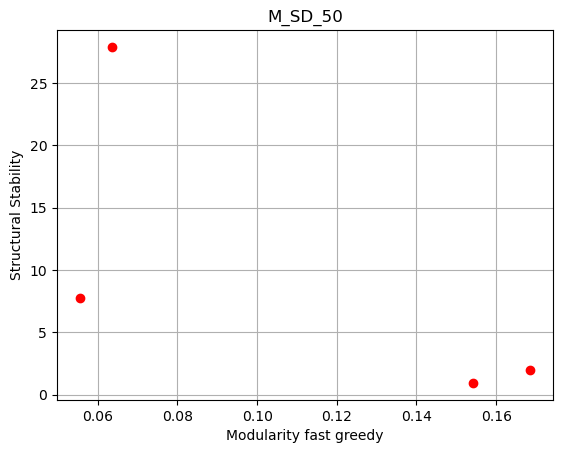

In [33]:
# Generating plots modularity
plt.plot(Modul_greedy, List_Stab[2], "ro")
plt.xlabel('Modularity fast greedy')
plt.ylabel('Structural Stability')
plt.title(Experiment)
plt.grid(True)
plt.show()

In [34]:
## Save the results in a CSV to compare
data = np.transpose(np.array([databases, meangrade, gammaminusbeta, sum_coop, sum_comp, 
                              Modul_eig, Modul_opt, Modul_greedy, List_Stab[2]]))

In [35]:
df_data = pd.DataFrame(data, columns = ['database','meangrade', 'gammaminusbeta', 'sum_coop', 'sum_comp',
                                        'Modularity_eig','Modularity_opt', 'Modularity_greedy','Struc_Stab'])

In [36]:
#df_data

In [37]:
df_data.to_csv('Result_CSV/'+Experiment+'.csv', index = False)